# 1 Imports

In [116]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_absolute_error
from category_encoders.target_encoder import TargetEncoder
from typing import Protocol, Any

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
import pandas as pd

sns.set_theme()

# 2 Helper functions

In [117]:
def get_target_encoders(data: pd.DataFrame, columns: list, target: str):
    encoders = []
    for col in columns:
        encoder = TargetEncoder(smoothing=2.0, min_samples_leaf=2)
        encoder.fit(data[col], data[target])
        encoders.append(encoder)
    return encoders


def plot_feature_influence(data: pd.DataFrame, feature: str, target_var: str, estimate=None):  
    subset = [target_var]
    if estimate:
        subset += [estimate]

    df_count = data.groupby([feature])[target_var].count()
    df_mean = data.groupby([feature])[subset].mean()

    fig, ax_left = plt.subplots(figsize=(8, 5))

    if data[feature].nunique() > 100:
        ax_left.fill_between(df_count.index, 0, df_count, color="blue", alpha=0.2, label="{} distribution".format(feature))  # type: ignore
    else:
        ax_left.bar(df_count.index, df_count, color="blue", alpha=0.2, label="{} distribution".format(feature))

    ax_left.set_ylabel("Count")
    ax_left.tick_params('x', rotation=90)
    ax_left.set_xlabel(feature)

    ax_right = ax_left.twinx()
    ax_right.scatter(df_mean.index, df_mean[target_var], color="green", label="Mean value of {}".format(target_var))
    ax_right.set_ylabel(target_var)

    if estimate:
        ax_right.scatter(df_mean.index, df_mean[estimate], color="magenta", label="Mean value of {}".format(estimate)) 

    lines = []
    labels = []
    for ax in fig.axes:
        line, label = ax.get_legend_handles_labels()
        lines.extend(line)
        labels.extend(label)  
    
    plt.grid(visible=None)
    plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.2))



class SklearnModel(Protocol):
    def fit(self, X, y, sample_weight=None) -> Any: ...
    def predict(self, X) -> Any: ...
    def score(self, X, y, sample_weight=None) -> Any: ...
    def set_params(self, **params) -> Any: ...


def get_scores(X_test: pd.DataFrame, y_test: pd.Series, model: SklearnModel, weights: pd.Series):
    mae = mean_absolute_error(y_test, model.predict(X_test), sample_weight=weights)
    mse = mean_squared_error(y_test, model.predict(X_test), sample_weight=weights)
    rmse = np.sqrt(mse)
    print("The mean absolute error (MAE) on test set: {:_.4f}".format(mae))
    print("The mean squared error (MSE) on test set: {:_.4f}".format(mse))
    print("The root mean squared error (RMSE) on test set: {:_.4f}".format(rmse))

# 3 Data Preprocessing

In [118]:

df_freq: pd.DataFrame = fetch_openml(data_id=41214, as_frame=True).get("data")  # type: ignore
df_sev: pd.DataFrame = fetch_openml(data_id=41215, as_frame=True).get("data")  # type: ignore

df_freq.set_index("IDpol", inplace=True)
df_sev_agg = df_sev.groupby("IDpol").agg(sum)
df_claims = df_freq.join(df_sev_agg).fillna(0)

### 3.1 Info

In [119]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 678013 entries, 1.0 to 6114330.0
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ClaimNb     678013 non-null  float64 
 1   Exposure    678013 non-null  float64 
 2   Area        678013 non-null  category
 3   VehPower    678013 non-null  float64 
 4   VehAge      678013 non-null  float64 
 5   DrivAge     678013 non-null  float64 
 6   BonusMalus  678013 non-null  float64 
 7   VehBrand    678013 non-null  category
 8   VehGas      678013 non-null  object  
 9   Density     678013 non-null  float64 
 10  Region      678013 non-null  category
dtypes: category(3), float64(7), object(1)
memory usage: 64.6+ MB


In [120]:
df_freq.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [121]:
df_sev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  float64
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(2)
memory usage: 416.4 KB


In [122]:
df_sev.describe()

,IDpol,ClaimAmount
count,2.663900e+04,2.663900e+04
mean,2.279864e+06,2.278536e+03
std,1.577202e+06,2.929748e+04
min,1.390000e+02,1.000000e+00
25%,1.087642e+06,6.868100e+02
50%,2.137413e+06,1.172000e+03
75%,3.180162e+06,1.228080e+03
max,6.113971e+06,4.075401e+06


### 3.2 Visualization

In [123]:
df_claims.describe(percentiles=[0.25, 0.5, 0.75, 0.98, 0.99], include="all")

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
count,678013.000000,678013.000000,678013,678013.000000,678013.000000,678013.000000,678013.000000,678013,678013,678013.000000,678013,6.780130e+05
unique,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN
top,NaN,NaN,C,NaN,NaN,NaN,NaN,B12,Regular,NaN,R24,NaN
freq,NaN,NaN,191880,NaN,NaN,NaN,NaN,166024,345877,NaN,160601,NaN
mean,0.053247,0.528750,NaN,6.454631,7.044265,45.499122,59.761502,NaN,NaN,1792.422405,NaN,8.835998e+01
std,0.240117,0.364442,NaN,2.050906,5.666232,14.137444,15.636658,NaN,NaN,3958.646564,NaN,5.822454e+03
min,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN,0.000000e+00
25%,0.000000,0.180000,NaN,5.000000,2.000000,34.000000,50.000000,NaN,NaN,92.000000,NaN,0.000000e+00
50%,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN,0.000000e+00
75%,0.000000,0.990000,NaN,7.000000,11.000000,55.000000,64.000000,NaN,NaN,1658.000000,NaN,0.000000e+00


array([[<AxesSubplot: title={'center': 'ClaimNb'}>,
        <AxesSubplot: title={'center': 'Exposure'}>,
        <AxesSubplot: title={'center': 'VehPower'}>],
       [<AxesSubplot: title={'center': 'VehAge'}>,
        <AxesSubplot: title={'center': 'DrivAge'}>,
        <AxesSubplot: title={'center': 'BonusMalus'}>],
       [<AxesSubplot: title={'center': 'Density'}>,
        <AxesSubplot: title={'center': 'ClaimAmount'}>, <AxesSubplot: >]],
      dtype=object)

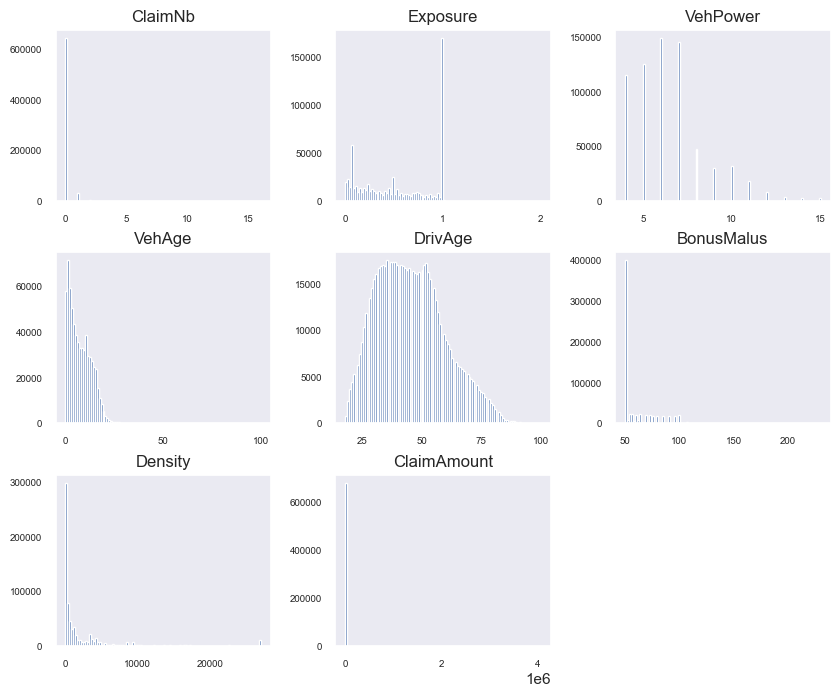

In [124]:
df_claims.hist(figsize=(10, 8), bins=100, grid=False, ylabelsize=7, xlabelsize=7)

In [125]:
df_claims_positive = df_claims[df_claims["ClaimAmount"] > 0]
df_claims_positive.describe(percentiles=[0.25, 0.5, 0.75, 0.98, 0.99, 0.995], include="all")

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
count,24944.000000,24944.000000,24944,24944.000000,24944.000000,24944.000000,24944.000000,24944,24944,24944.000000,24944,2.494400e+04
unique,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN
top,NaN,NaN,C,NaN,NaN,NaN,NaN,B1,Diesel,NaN,R24,NaN
freq,NaN,NaN,6730,NaN,NaN,NaN,NaN,6509,12700,NaN,6262,NaN
mean,1.060175,0.692669,NaN,6.468970,7.386225,45.139793,64.930164,NaN,NaN,1984.306166,NaN,2.401749e+03
std,0.289929,0.313969,NaN,2.012848,5.173621,14.658487,19.864719,NaN,NaN,4119.719566,NaN,3.026475e+04
min,1.000000,0.002740,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,2.000000,NaN,1.000000e+00
25%,1.000000,0.450000,NaN,5.000000,3.000000,34.000000,50.000000,NaN,NaN,111.000000,NaN,7.497875e+02
50%,1.000000,0.760000,NaN,6.000000,7.000000,45.000000,55.000000,NaN,NaN,495.000000,NaN,1.172000e+03
75%,1.000000,1.000000,NaN,7.000000,11.000000,54.000000,76.000000,NaN,NaN,2120.000000,NaN,1.346400e+03


array([[<AxesSubplot: title={'center': 'ClaimNb'}>,
        <AxesSubplot: title={'center': 'Exposure'}>,
        <AxesSubplot: title={'center': 'VehPower'}>],
       [<AxesSubplot: title={'center': 'VehAge'}>,
        <AxesSubplot: title={'center': 'DrivAge'}>,
        <AxesSubplot: title={'center': 'BonusMalus'}>],
       [<AxesSubplot: title={'center': 'Density'}>,
        <AxesSubplot: title={'center': 'ClaimAmount'}>, <AxesSubplot: >]],
      dtype=object)

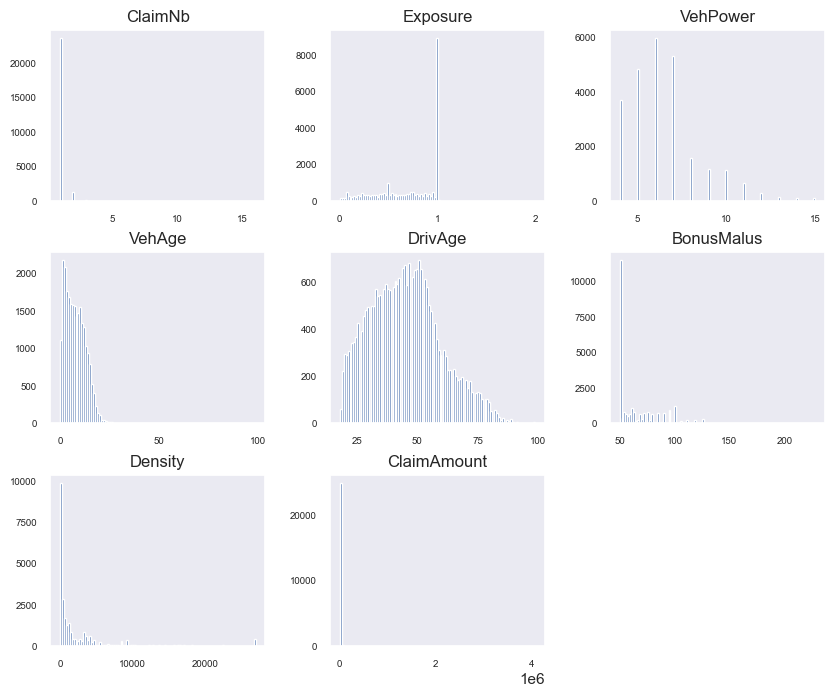

In [126]:
df_claims_positive.hist(figsize=(10, 8), bins=100, grid=False, ylabelsize=7, xlabelsize=7)

### 3.3 Preprocessing

In [127]:
# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df_claims["ClaimNb"].clip(upper=2, inplace=True)
df_claims["Exposure"].clip(upper=1, inplace=True)
df_claims["ClaimAmount"].clip(upper=35_000, inplace=True)
df_claims["BonusMalus"].clip(upper=125, inplace=True)

In [128]:
df_claims.describe(percentiles=[0.25, 0.5, 0.75, 0.98, 0.99, 0.995], include="all")

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
count,678013.000000,678013.000000,678013,678013.000000,678013.000000,678013.000000,678013.000000,678013,678013,678013.000000,678013,678013.000000
unique,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN
top,NaN,NaN,C,NaN,NaN,NaN,NaN,B12,Regular,NaN,R24,NaN
freq,NaN,NaN,191880,NaN,NaN,NaN,NaN,166024,345877,NaN,160601,NaN
mean,0.053011,0.528545,NaN,6.454631,7.044265,45.499122,59.736981,NaN,NaN,1792.422405,NaN,66.006341
std,0.236119,0.364081,NaN,2.050906,5.666232,14.137444,15.509950,NaN,NaN,3958.646564,NaN,739.095782
min,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN,0.000000
25%,0.000000,0.180000,NaN,5.000000,2.000000,34.000000,50.000000,NaN,NaN,92.000000,NaN,0.000000
50%,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN,0.000000
75%,0.000000,0.990000,NaN,7.000000,11.000000,55.000000,64.000000,NaN,NaN,1658.000000,NaN,0.000000


In [129]:
# Set ClaimNb to 0, if ClaimAmount = 0
df_claims.loc[(df_claims["ClaimAmount"] == 0) & (df_claims["ClaimNb"] >= 1), "ClaimNb"] = 0

# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df_claims["PurePremium"] = df_claims["ClaimAmount"] / df_claims["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df_claims["Frequency"] = df_claims["ClaimNb"] / df_claims["Exposure"]
df_claims["AvgClaimAmount"] = df_claims["ClaimAmount"] / np.fmax(df_claims["ClaimNb"], 1)

df_claims.fillna(0, inplace=True)

In [130]:
df_claims.describe(percentiles=[0.25, 0.5, 0.75, 0.98, 0.99, 0.995], include="all")

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
count,678013.000000,678013.000000,678013,678013.000000,678013.000000,678013.000000,678013.000000,678013,678013,678013.000000,678013,678013.000000,6.780130e+05,678013.000000,678013.000000
unique,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN,NaN,NaN,NaN
top,NaN,NaN,C,NaN,NaN,NaN,NaN,B12,Regular,NaN,R24,NaN,NaN,NaN,NaN
freq,NaN,NaN,191880,NaN,NaN,NaN,NaN,166024,345877,NaN,160601,NaN,NaN,NaN,NaN
mean,0.038816,0.528545,NaN,6.454631,7.044265,45.499122,59.736981,NaN,NaN,1792.422405,NaN,66.006341,2.682212e+02,0.117752,61.850533
std,0.203378,0.364081,NaN,2.050906,5.666232,14.137444,15.509950,NaN,NaN,3958.646564,NaN,739.095782,1.156071e+04,2.001096,687.416764
min,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.180000,NaN,5.000000,2.000000,34.000000,50.000000,NaN,NaN,92.000000,NaN,0.000000,0.000000e+00,0.000000,0.000000
50%,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN,0.000000,0.000000e+00,0.000000,0.000000
75%,0.000000,0.990000,NaN,7.000000,11.000000,55.000000,64.000000,NaN,NaN,1658.000000,NaN,0.000000,0.000000e+00,0.000000,0.000000


### 3.4 Train-Test Split

In [131]:
# Create mask for splitting test and training data
np.random.seed(0)
train_mask = np.random.rand(df_claims.shape[0]) < 0.8

In [132]:
df_claims[train_mask].sample(3)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
IDpol,,,,,,,,,,,,,,,
144212.0,0.0,0.43,E,7.0,10.0,34.0,54.0,B2,Diesel,3657.0,R82,0.0,0.0,0.0,0.0
3150917.0,0.0,0.01,C,5.0,3.0,30.0,57.0,B2,Diesel,182.0,R24,0.0,0.0,0.0,0.0
6112589.0,0.0,0.04,D,8.0,4.0,58.0,50.0,B12,Diesel,1221.0,R83,0.0,0.0,0.0,0.0


In [133]:
df_claims[~train_mask].sample(3)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
IDpol,,,,,,,,,,,,,,,
112879.0,0.0,0.50,C,4.0,10.0,38.0,100.0,B6,Regular,388.0,R93,0.0,0.0,0.0,0.0
1100868.0,0.0,1.00,C,7.0,5.0,54.0,50.0,B4,Diesel,461.0,R53,0.0,0.0,0.0,0.0
1021687.0,0.0,0.46,A,7.0,0.0,55.0,50.0,B5,Diesel,43.0,R24,0.0,0.0,0.0,0.0


# 4 Frequency Estimation

In [134]:
target_freq = "Frequency"

### 4.1 Feature Engineering

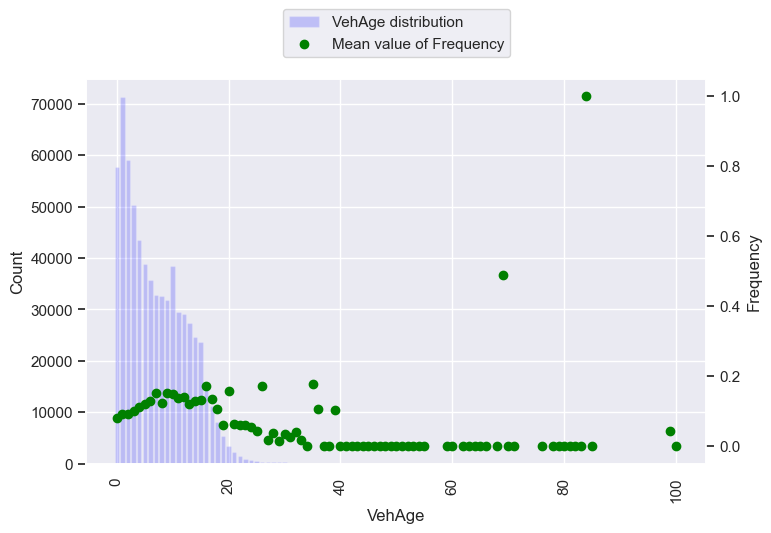

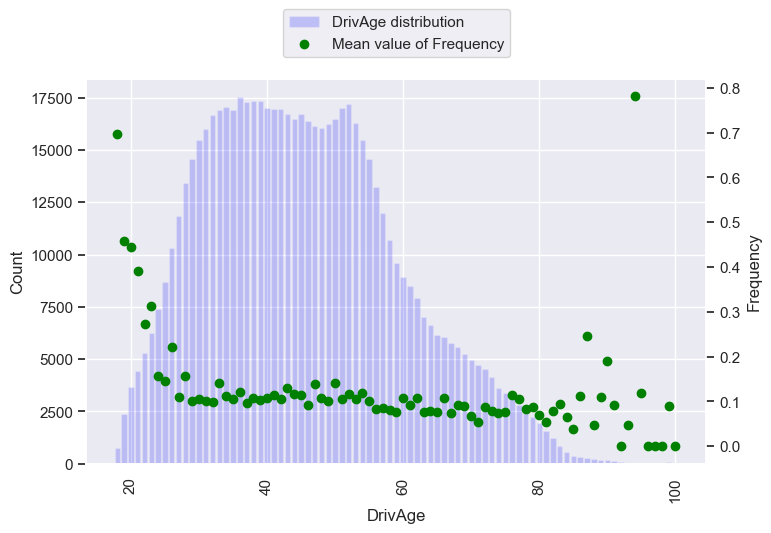

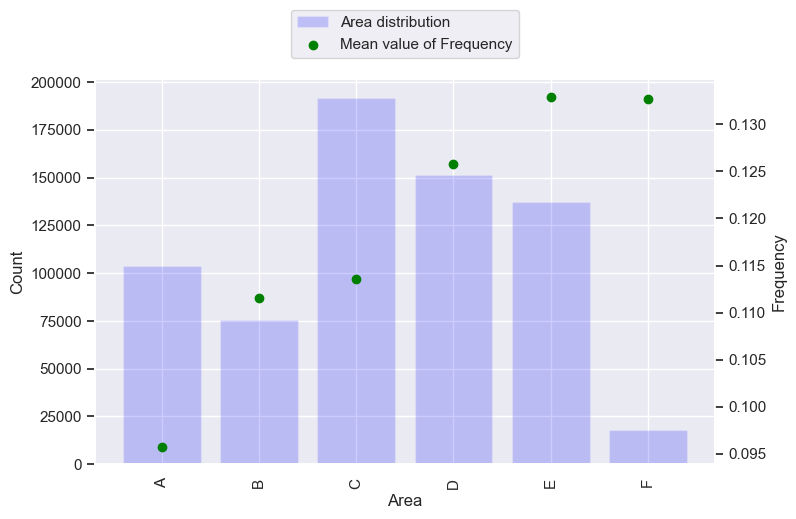

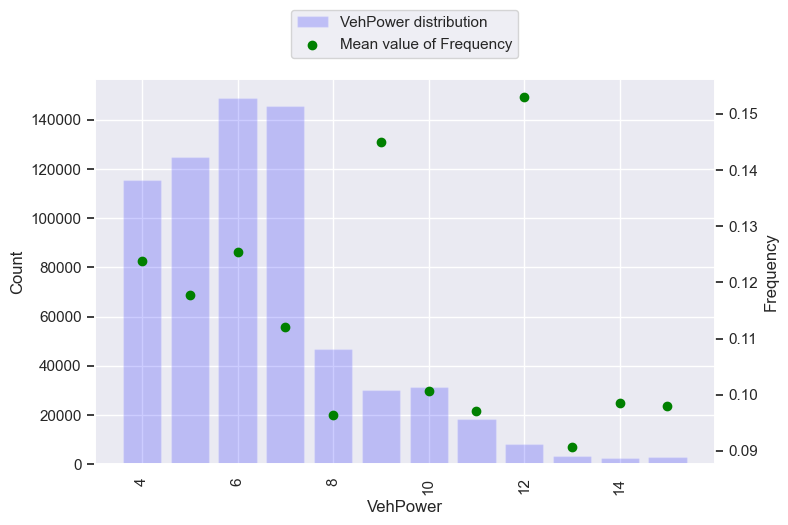

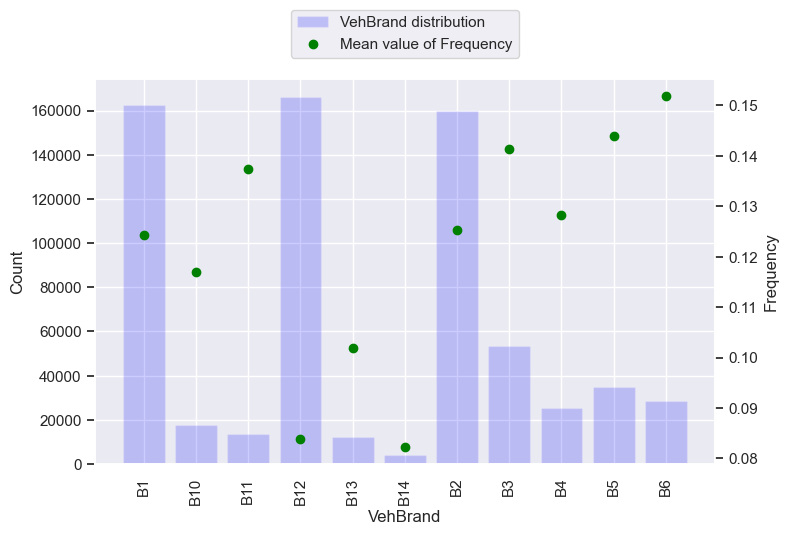

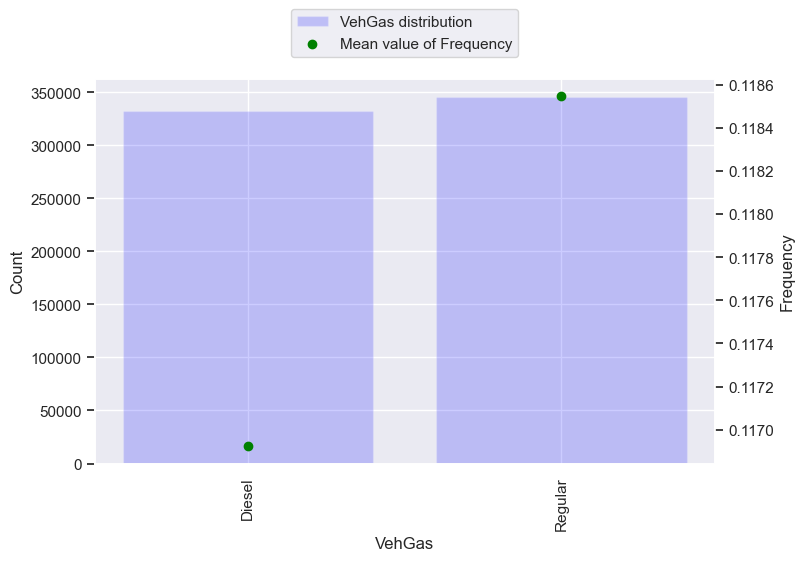

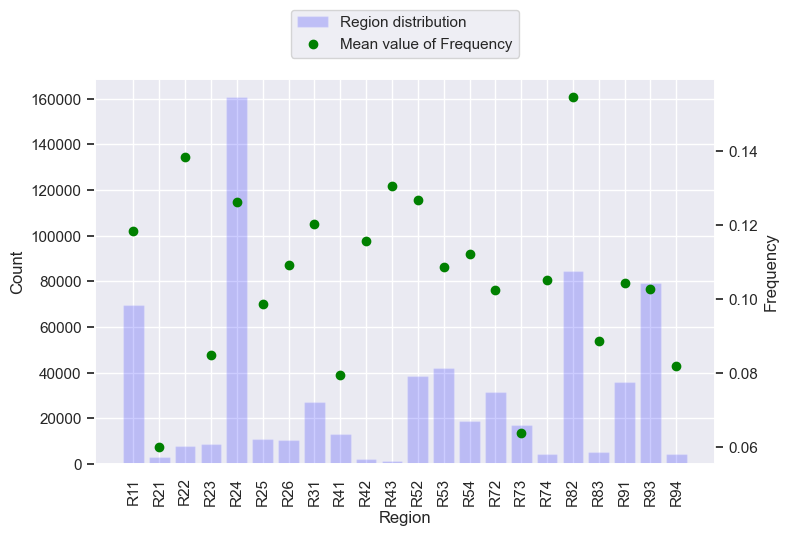

In [135]:
for feature in ["VehAge", "DrivAge", "Area", "VehPower", "VehBrand", "VehGas", "Region"]:
    plot_feature_influence(df_claims, feature, target_freq)

In [136]:
def prep_frequency_estimation(data: pd.DataFrame, encoders: list[TargetEncoder]):
    df = data.copy()
    for encoder in encoders:
        column = encoder.cols
        df[column] = encoder.transform(df[column])

    df["DriverAgeGroup"] = pd.cut(df["DrivAge"], [0, 27, 70, 100], labels=["YoungDriver", "AvgAgeDriver", "OldDriver"])
    df["OldVehicle"] = df["VehAge"].apply(lambda x: 1 if x > 17 else 0)
    df["VehGas"] = df["VehGas"].map({"Diesel": 0, "Regular": 1})

    dummies = pd.get_dummies(df["DriverAgeGroup"])
    df = pd.concat([df, dummies], axis=1)
    return df


target_encoders_freq = get_target_encoders(df_claims, ["Region", "Area", "VehBrand"], target_freq)
df_frequency_enc = prep_frequency_estimation(df_claims, target_encoders_freq)

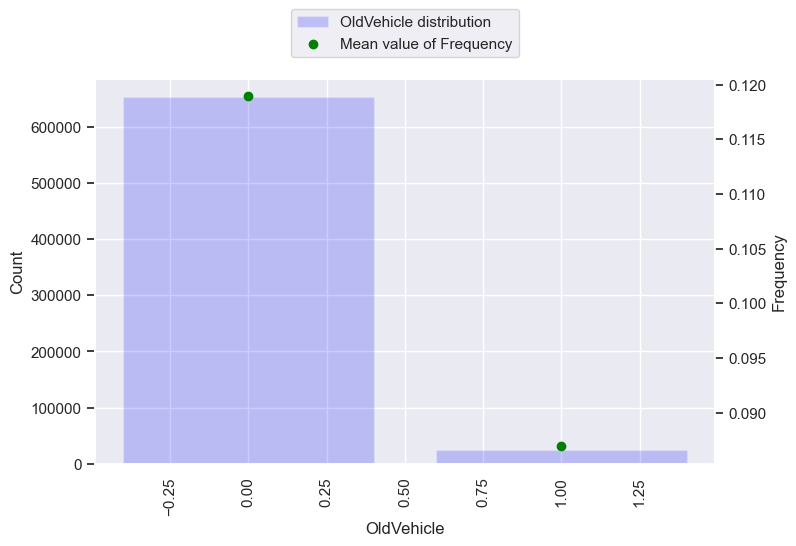

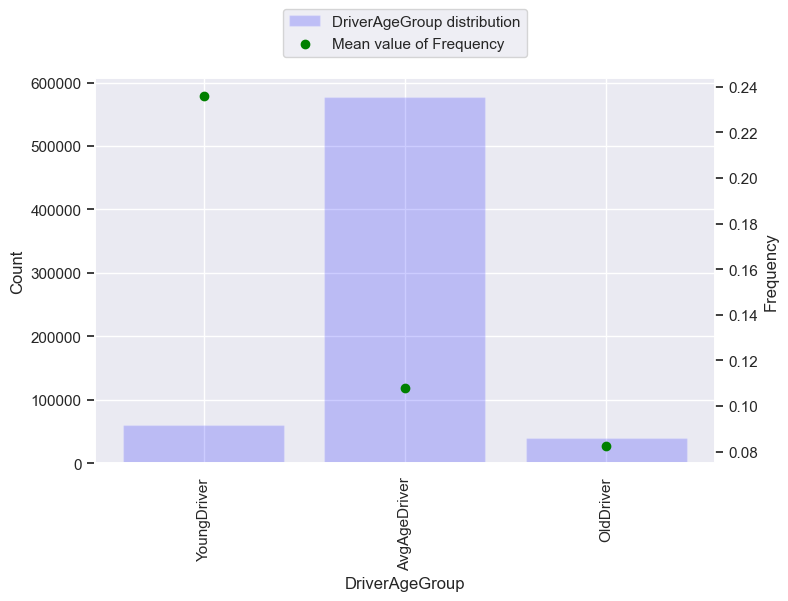

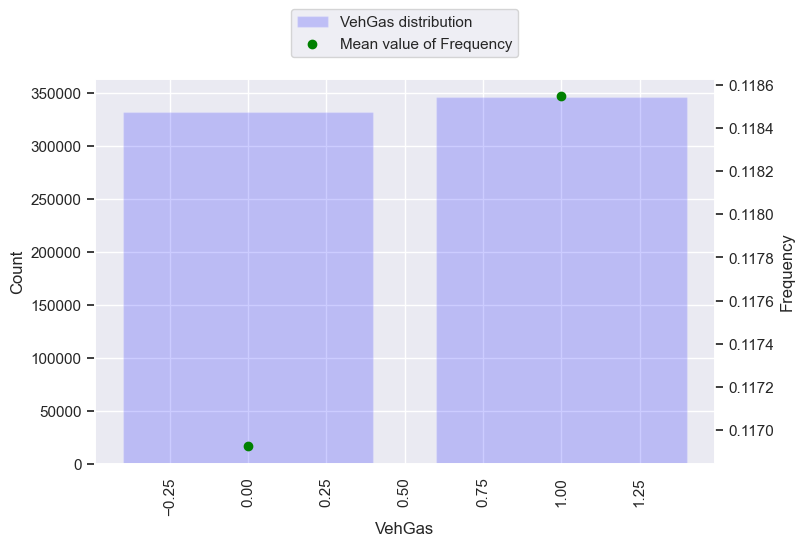

In [137]:
for feature in ["OldVehicle", "DriverAgeGroup", "VehGas"]:
    plot_feature_influence(df_frequency_enc, feature, target_freq)

### 4.2 Feature Selection

In [138]:
features_freq = [
    "OldVehicle",
    "YoungDriver",
    "AvgAgeDriver",
    "OldDriver",
    "BonusMalus",
    "Density",
    "Region",
    "Area",
    "VehGas",
    "VehBrand"
]

<AxesSubplot: >

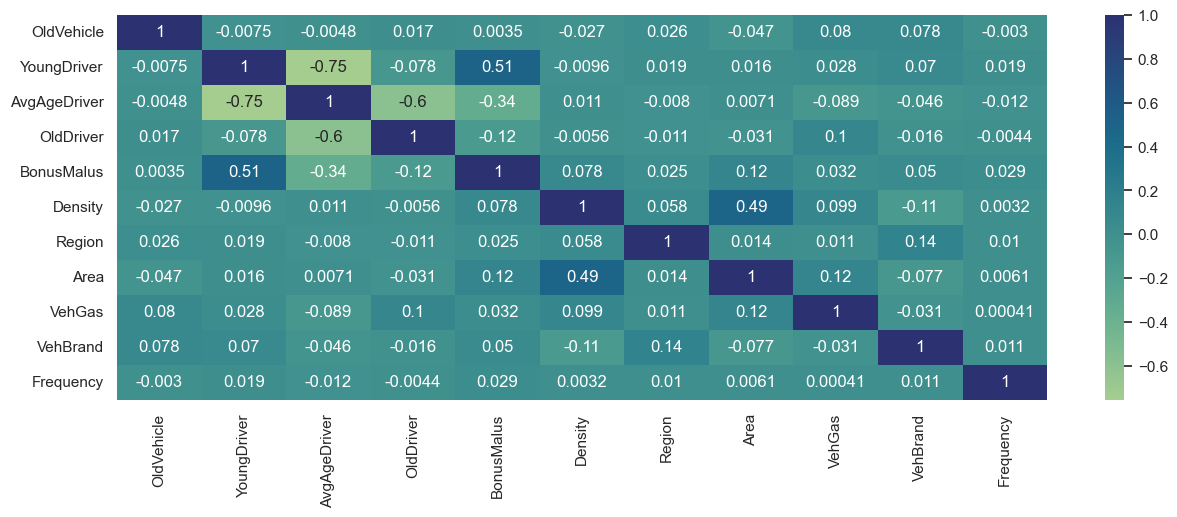

In [139]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df_frequency_enc[features_freq + [target_freq]].corr(), annot=True, fmt='.2g', cmap="crest")

### 4.3 XGBoost Regression

In [140]:
xgb_regressor = xgb.XGBRegressor(objective="count:poisson", max_leaves=128)
xgb_regressor.fit(
    X=df_frequency_enc[train_mask][features_freq],
    y=df_frequency_enc[train_mask][target_freq],
    sample_weight=df_frequency_enc[train_mask]["Exposure"]
)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0.699999988, max_depth=6, max_leaves=128,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='count:poisson', predictor='auto', ...)

In [141]:
get_scores(
    X_test=df_frequency_enc[~train_mask][features_freq],
    y_test=df_frequency_enc[~train_mask][target_freq],
    model=xgb_regressor,
    weights=df_frequency_enc[~train_mask]["Exposure"]
)

The mean absolute error (MAE) on test set: 0.1346
The mean squared error (MSE) on test set: 0.2230
The root mean squared error (RMSE) on test set: 0.4722


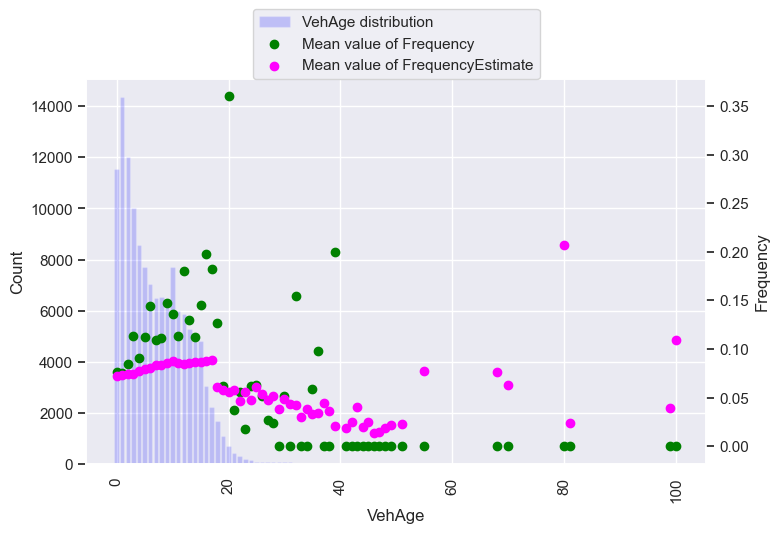

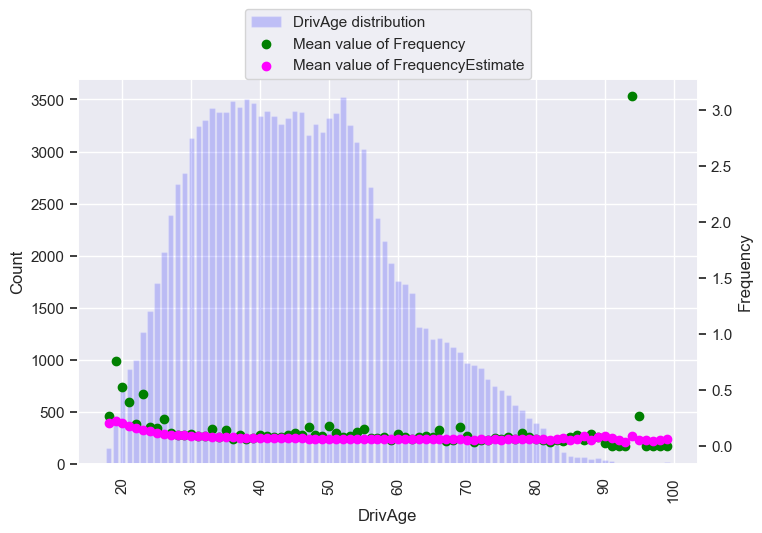

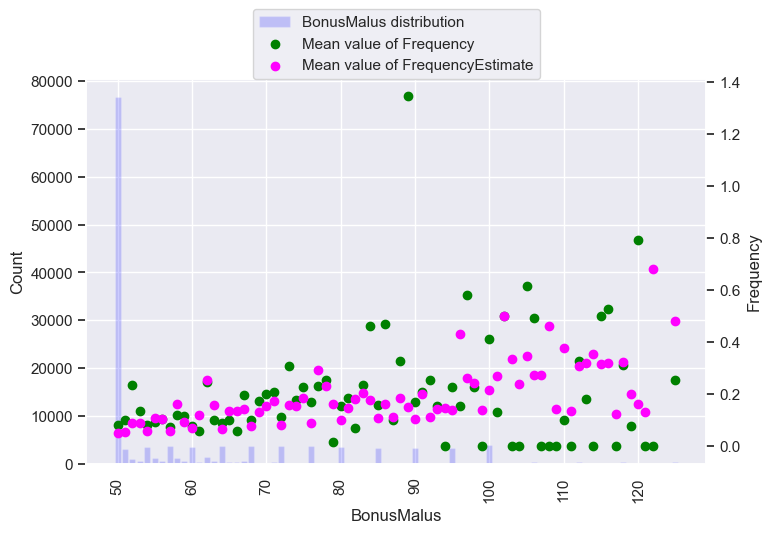

In [142]:
freq_test = df_frequency_enc[~train_mask].copy()
freq_test["FrequencyEstimate"] = xgb_regressor.predict(freq_test[features_freq])

for feature in ["VehAge", "DrivAge", "BonusMalus"]:
    plot_feature_influence(freq_test, feature, target_freq, estimate="FrequencyEstimate")

<AxesSubplot: >

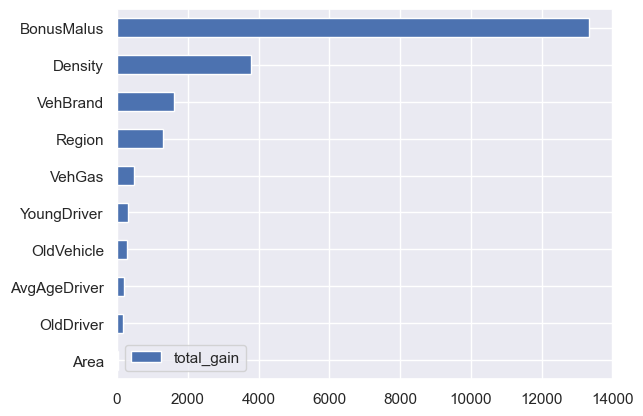

In [143]:
# Get feature importance of each feature. For tree model Importance type can be defined as:

# 'weight': the number of times a feature is used to split the data across all trees.
# 'gain': the average gain across all splits the feature is used in.
# 'cover': the average coverage across all splits the feature is used in.
# 'total_gain': the total gain across all splits the feature is used in.
# 'total_cover': the total coverage across all splits the feature is used in.'
imp_type = "total_gain"
f_importance = xgb_regressor.get_booster().get_score(importance_type=imp_type)
importance_df = pd.DataFrame.from_dict(f_importance, orient="index", columns=[imp_type]).sort_values(by=[imp_type]) 
importance_df.plot.barh()

### 4.4 Poisson Regression

In [144]:
glm_freq = PoissonRegressor()
glm_freq.fit(
    X=df_frequency_enc[train_mask][features_freq],
    y=df_frequency_enc[train_mask][target_freq],
    sample_weight=df_frequency_enc[train_mask]["Exposure"]
)

c:\Users\mxja\OneDrive - Deutsche Telekom AG\Workspace\2022_claims_regression\.venv\lib\site-packages\sklearn\linear_model\_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_per_sample + l2_reg_strength * weights


PoissonRegressor()

In [145]:
get_scores(
    X_test=df_frequency_enc[~train_mask][features_freq],
    y_test=df_frequency_enc[~train_mask][target_freq],
    model=glm_freq,
    weights=df_frequency_enc[~train_mask]["Exposure"]
)

The mean absolute error (MAE) on test set: 0.1386
The mean squared error (MSE) on test set: 0.2255
The root mean squared error (RMSE) on test set: 0.4749


# 5 Severity Estimation

In [146]:
target_sev = "AvgClaimAmount"
sev_mask = df_claims[target_sev] > 0
df_claims[sev_mask].sample(3)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
IDpol,,,,,,,,,,,,,,,
6017766.0,2.0,0.01,B,5.0,5.0,36.0,50.0,B12,Regular,66.0,R93,8859.84,885984.000000,200.000000,4429.92
2131099.0,1.0,0.75,C,6.0,7.0,33.0,95.0,B6,Diesel,238.0,R82,1172.00,1562.666667,1.333333,1172.00
136228.0,1.0,1.00,C,5.0,10.0,36.0,50.0,B2,Diesel,155.0,R24,1128.12,1128.120000,1.000000,1128.12


### 5.1 Feature Engineering

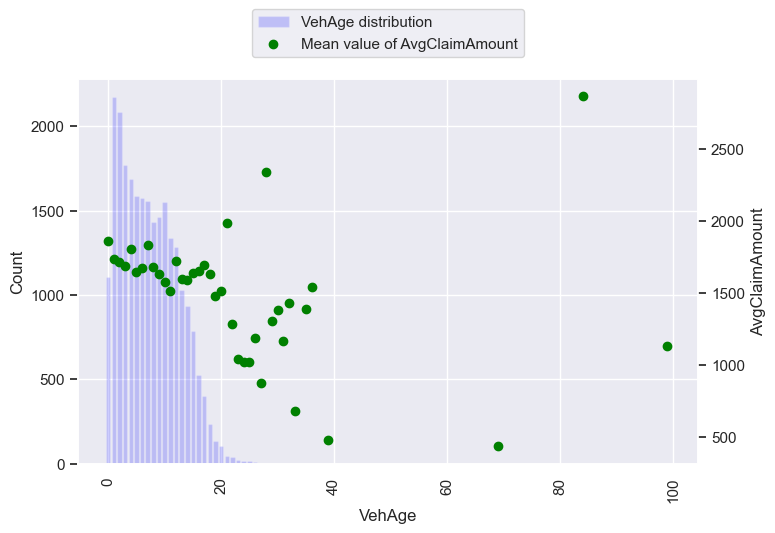

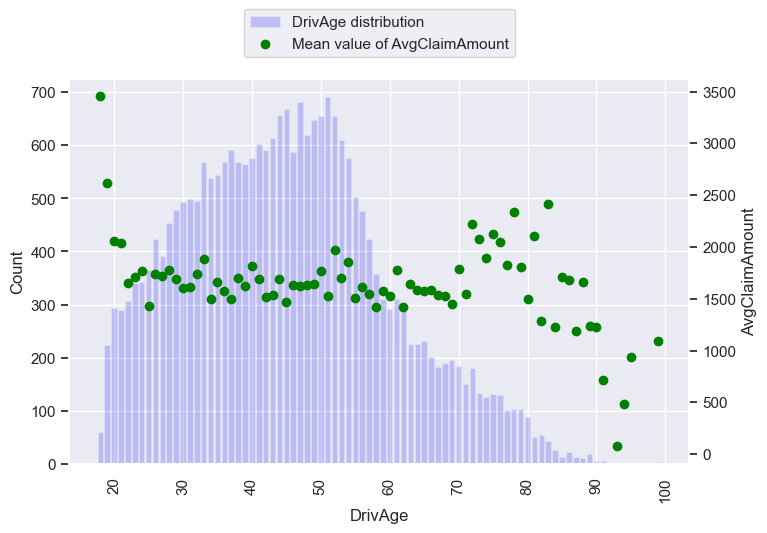

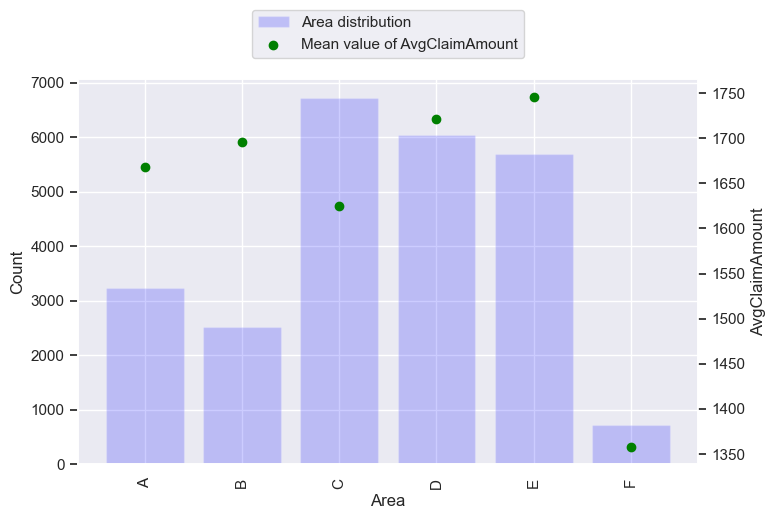

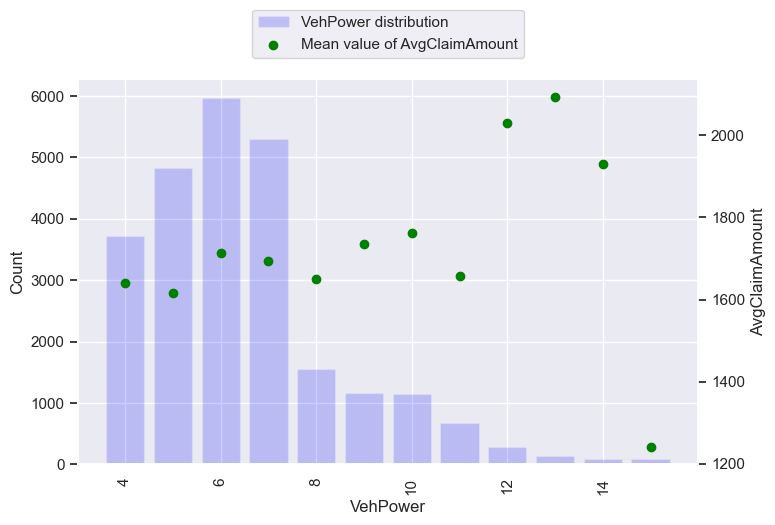

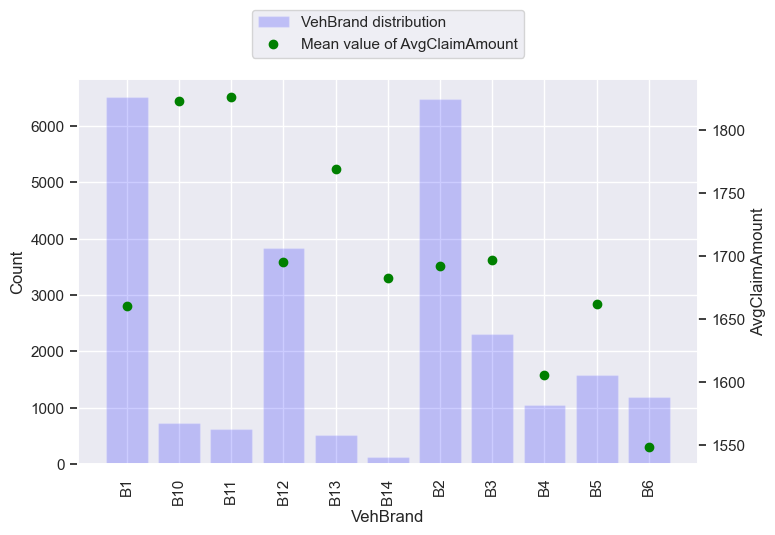

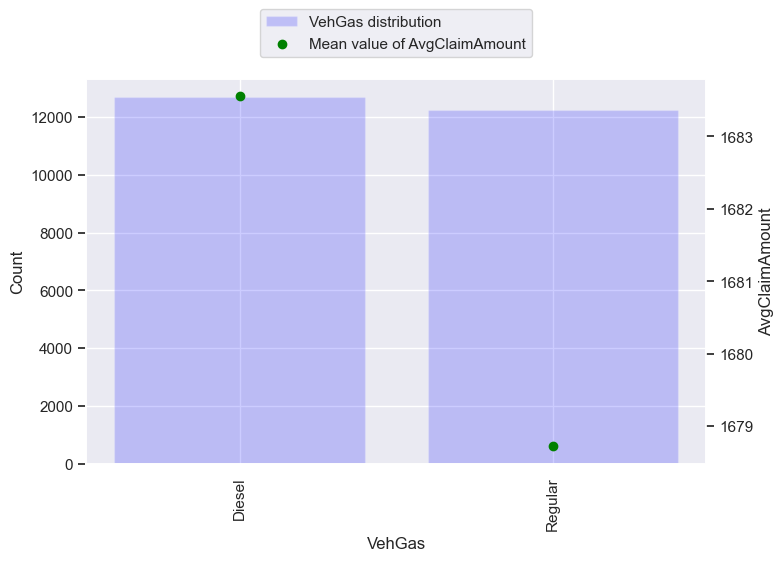

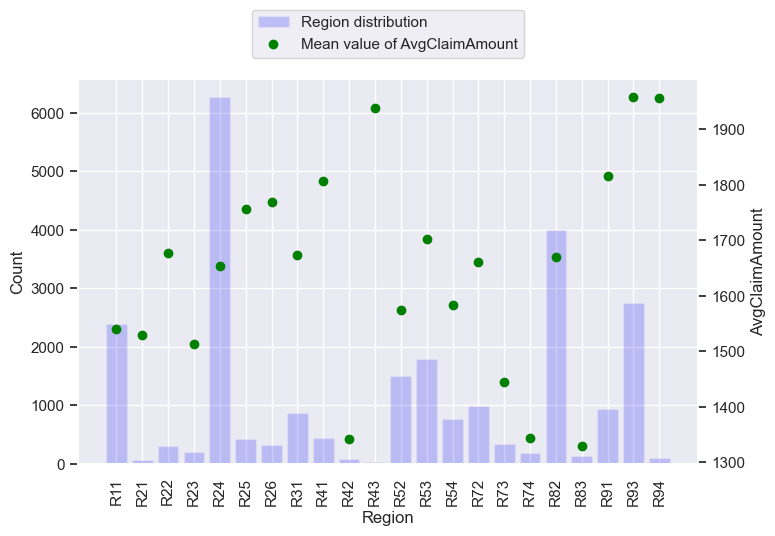

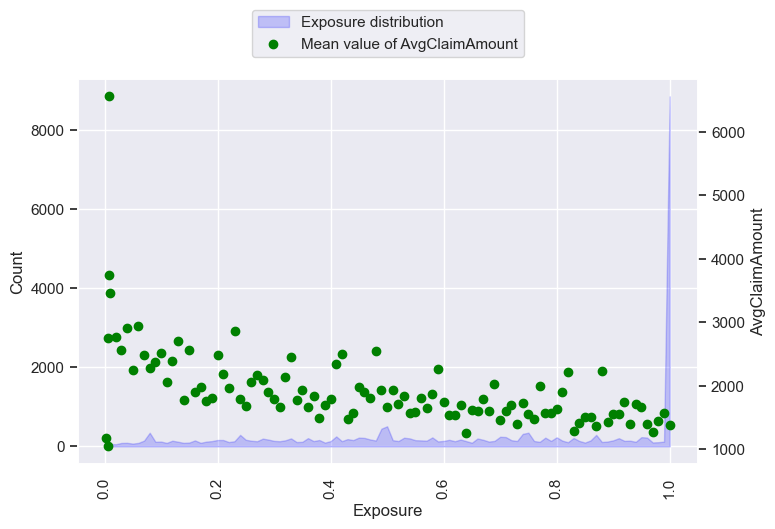

In [147]:
for feature in ["VehAge", "DrivAge", "Area", "VehPower", "VehBrand", "VehGas", "Region", "Exposure"]:
    plot_feature_influence(df_claims[sev_mask], feature, target_sev)

In [148]:
def prep_severity_estimation(data: pd.DataFrame, encoders: list[TargetEncoder]):
    df = data.copy()
    for encoder in encoders:
        column = encoder.cols
        df[column] = encoder.transform(df[column])

    df["DriverAgeGroup"] = pd.cut(df["DrivAge"], [0, 27, 70, 100], labels=["YoungDriver", "AvgAgeDriver", "OldDriver"])
    df["OldVehicle"] = df["VehAge"].apply(lambda x: 1 if x > 17 else 0)
    df["PowerfulVeh"] = df["VehPower"].apply(lambda x: 1 if x > 8 else 0)

    dummies = pd.get_dummies(df["DriverAgeGroup"])
    df = pd.concat([df, dummies], axis=1)
    return df


target_encoders_sev = get_target_encoders(df_claims[sev_mask], ["Region", "Area", "VehBrand"], target_sev)
df_severity_enc = prep_severity_estimation(df_claims, target_encoders_sev)

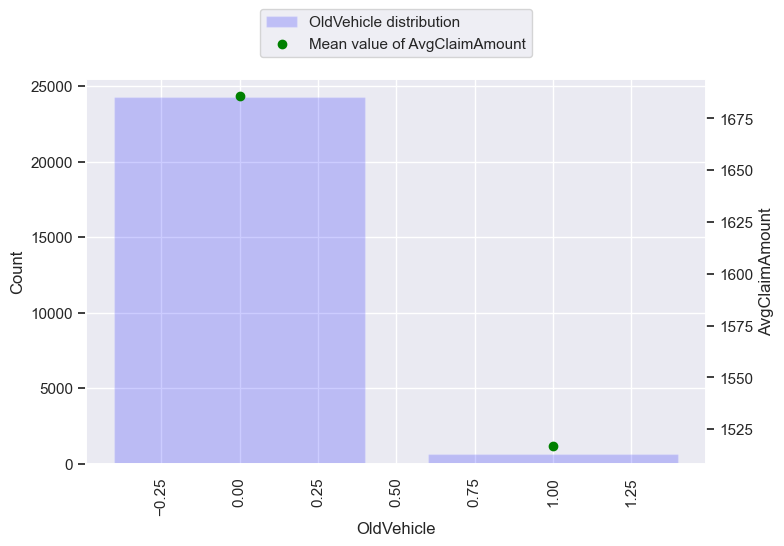

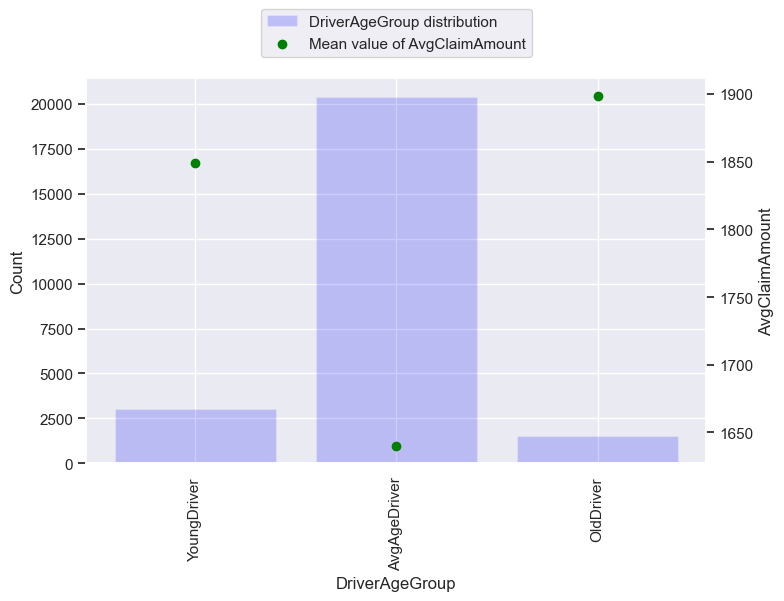

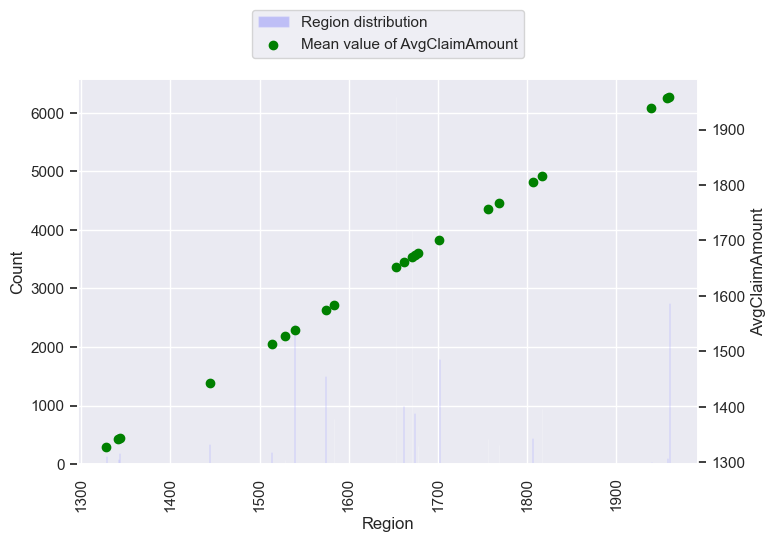

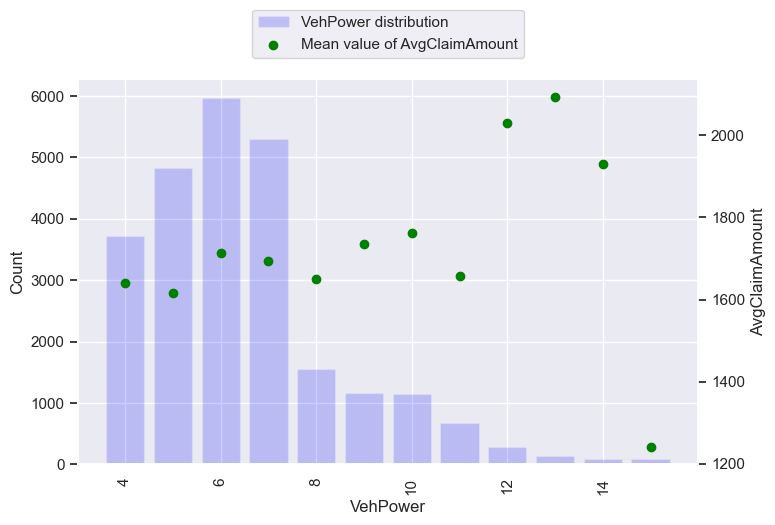

In [149]:
for feature in ["OldVehicle", "DriverAgeGroup", "Region", "VehPower"]:
    plot_feature_influence(df_severity_enc[sev_mask], feature, target_sev)

### 5.2 Feature Selection

In [150]:
features_sev = [
    "OldVehicle",
    "YoungDriver",
    "AvgAgeDriver",
    "OldDriver",
    "PowerfulVeh",
    "BonusMalus",
    "Density",
    "Region",
    "Area",
    "VehBrand"
]

<AxesSubplot: >

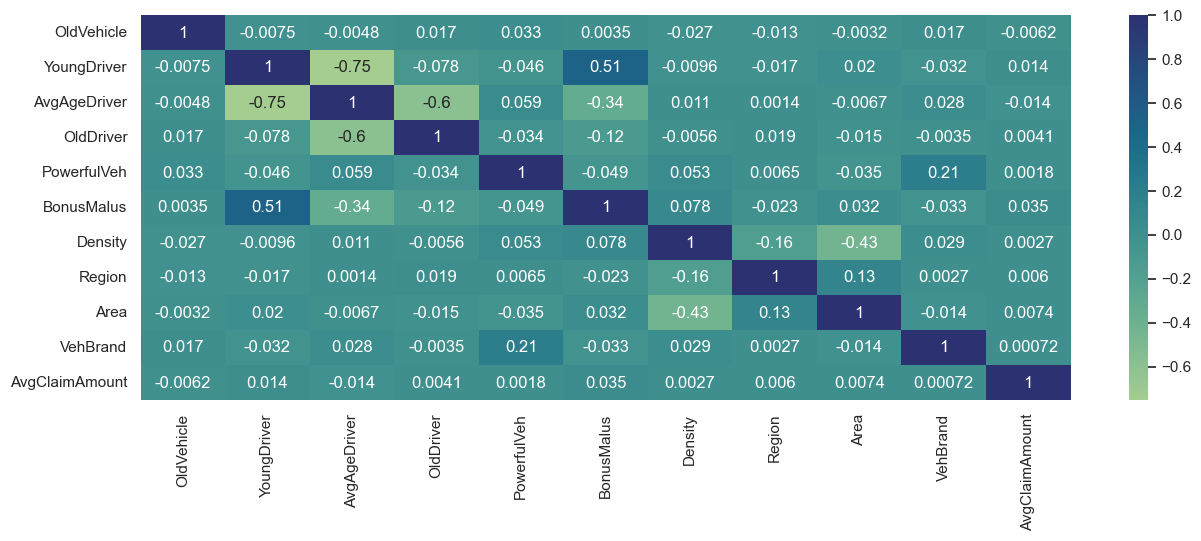

In [151]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df_severity_enc[features_sev + [target_sev]].corr(), annot=True, fmt='.2g', cmap="crest")

In [152]:
X_train_sev, X_test_sev, y_train_sev, y_test_sev, df_train_sev, df_test_sev = train_test_split(
    df_severity_enc[features_sev],
    df_severity_enc[target_sev],
    df_severity_enc,
    test_size=0.2
)

df_train_sev = pd.DataFrame(df_train_sev)
df_test_sev = pd.DataFrame(df_test_sev)

### 5.3 XGBoost Regression

In [153]:
xgb_sev = xgb.XGBRegressor(objective="reg:gamma", max_leaves=128)
xgb_sev.fit(
    X=df_severity_enc[train_mask & sev_mask][features_sev],
    y=df_severity_enc[train_mask & sev_mask][target_sev],
    sample_weight=df_severity_enc[train_mask & sev_mask]["ClaimNb"]
)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=128, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:gamma', predictor='auto', ...)

In [154]:
get_scores(
    X_test=df_severity_enc[~train_mask & sev_mask][features_sev],
    y_test=df_severity_enc[~train_mask & sev_mask][target_sev],
    model=xgb_sev,
    weights=df_severity_enc[~train_mask & sev_mask]["ClaimNb"]
)

The mean absolute error (MAE) on test set: 1_202.1382
The mean squared error (MSE) on test set: 8_668_147.2180
The root mean squared error (RMSE) on test set: 2_944.1717


In [155]:
# Resulting model: average claim amount per claim
# Conditional on having at least one claim, and cannot be used to predict the average claim amount per policy in general
print("Mean AvgClaim Amount per policy: {:_.2f} ".format(df_claims[train_mask][target_sev].mean()))
print("Mean AvgClaim Amount | NbClaim > 0: {:_.2f}".format(df_claims[train_mask & sev_mask][target_sev].mean()))
print("Predicted Mean AvgClaim Amount | NbClaim > 0: {:_.2f}".format(xgb_sev.predict(df_severity_enc[train_mask & sev_mask][features_sev]).mean()))

Mean AvgClaim Amount per policy: 62.43 
Mean AvgClaim Amount | NbClaim > 0: 1_687.64
Predicted Mean AvgClaim Amount | NbClaim > 0: 1_518.19


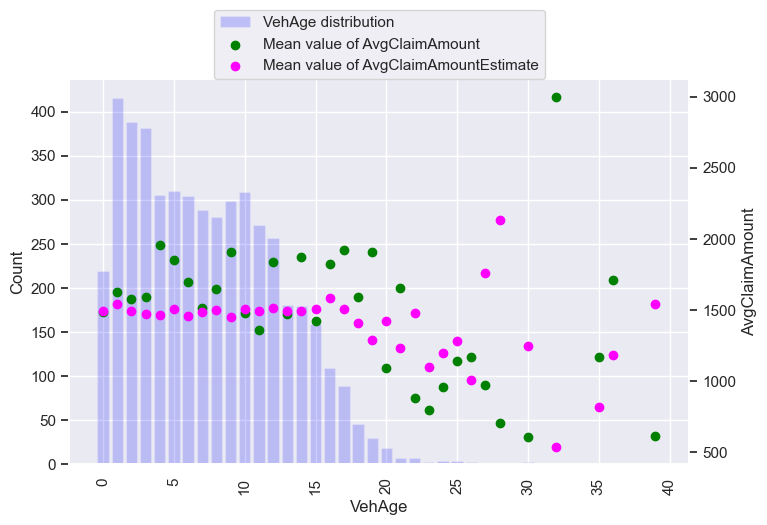

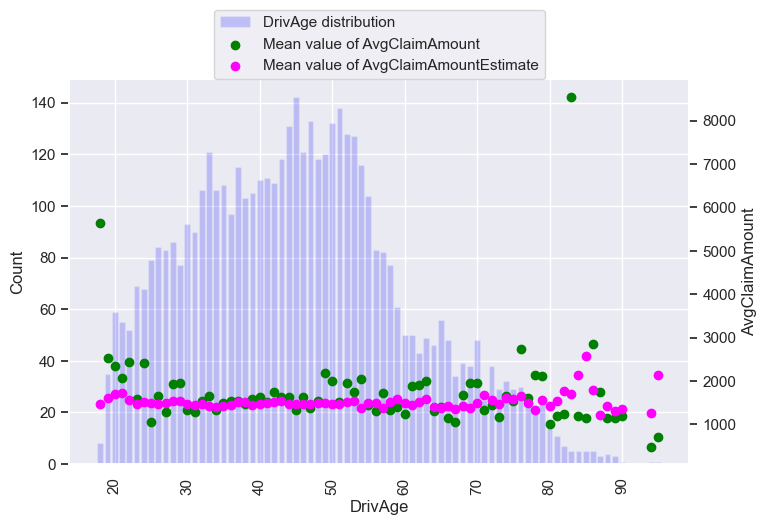

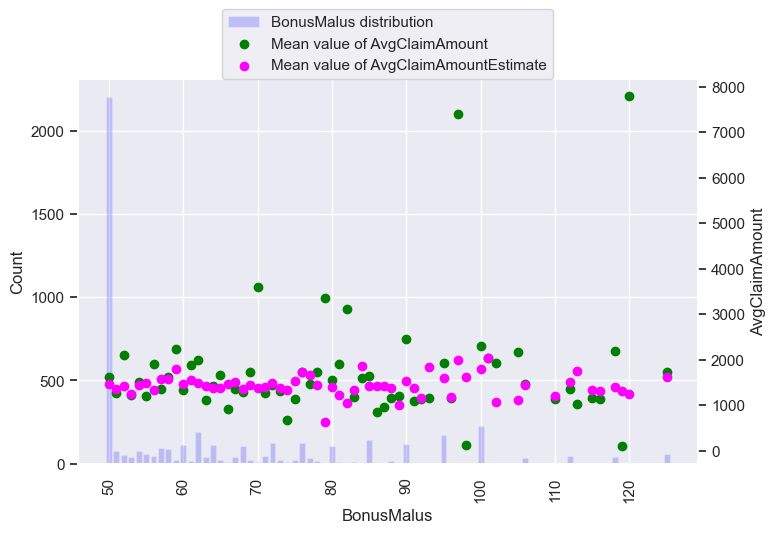

In [156]:
sev_test = df_severity_enc[~train_mask & sev_mask].copy()
sev_test["AvgClaimAmountEstimate"] = xgb_sev.predict(sev_test[features_sev])

for feature in ["VehAge", "DrivAge", "BonusMalus"]:
    plot_feature_influence(sev_test, feature, target_sev, estimate="AvgClaimAmountEstimate")

<AxesSubplot: >

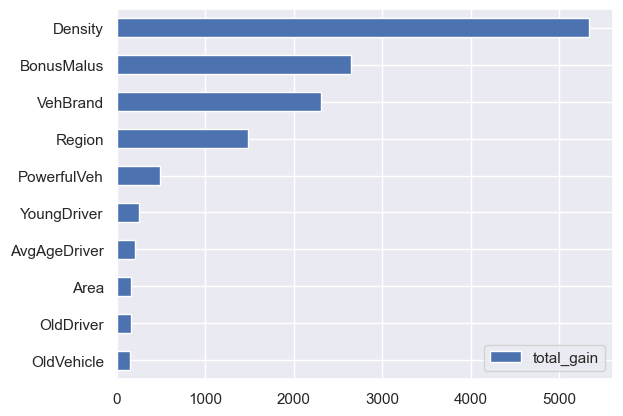

In [157]:
# Get feature importance of each feature. For tree model Importance type can be defined as:

# 'weight': the number of times a feature is used to split the data across all trees.
# 'gain': the average gain across all splits the feature is used in.
# 'cover': the average coverage across all splits the feature is used in.
# 'total_gain': the total gain across all splits the feature is used in.
# 'total_cover': the total coverage across all splits the feature is used in.'
imp_type = "total_gain"
f_importance = xgb_sev.get_booster().get_score(importance_type=imp_type)
importance_df = pd.DataFrame.from_dict(f_importance, orient="index", columns=[imp_type]).sort_values(by=[imp_type]) 
importance_df.plot.barh()

# 6 Pure Premium Estimation

In [158]:
def estimate_pure_premium(data: pd.DataFrame, freq_model: SklearnModel, sev_model: SklearnModel):
    frequency_data = prep_frequency_estimation(data, target_encoders_freq)
    severity_data = prep_severity_estimation(data, target_encoders_sev)

    frequency_estimate = freq_model.predict(frequency_data[features_freq])
    severity_estimate = sev_model.predict(severity_data[features_sev])

    return frequency_estimate * severity_estimate

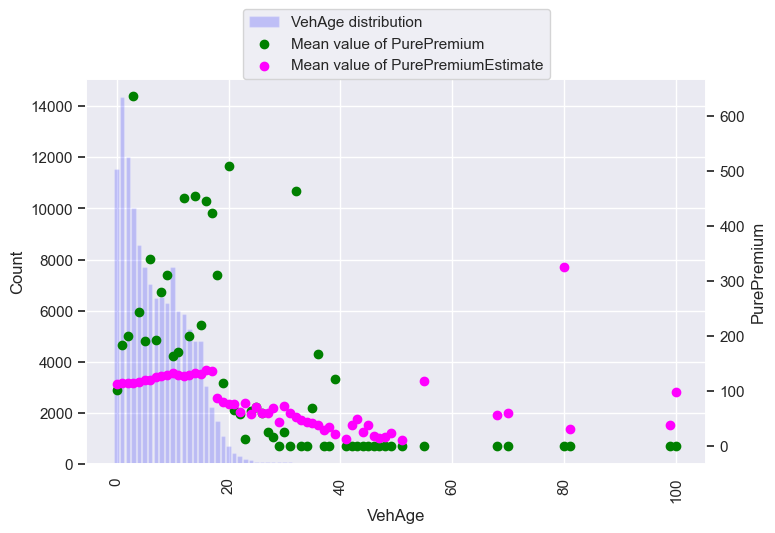

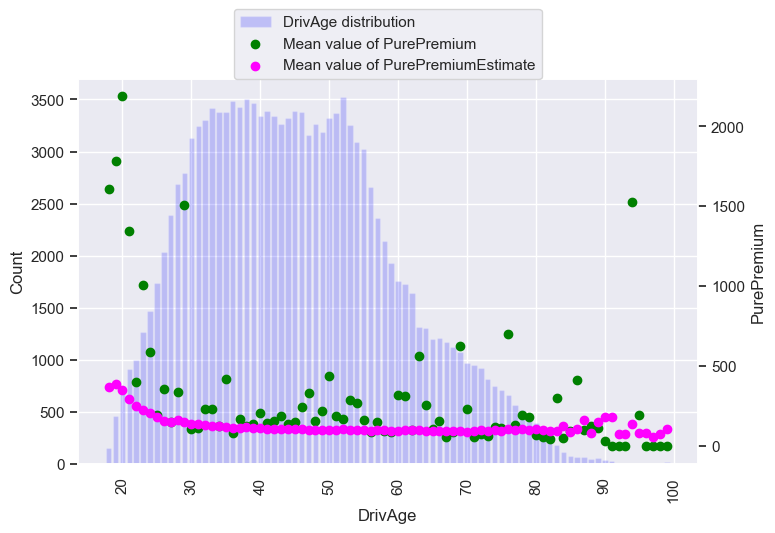

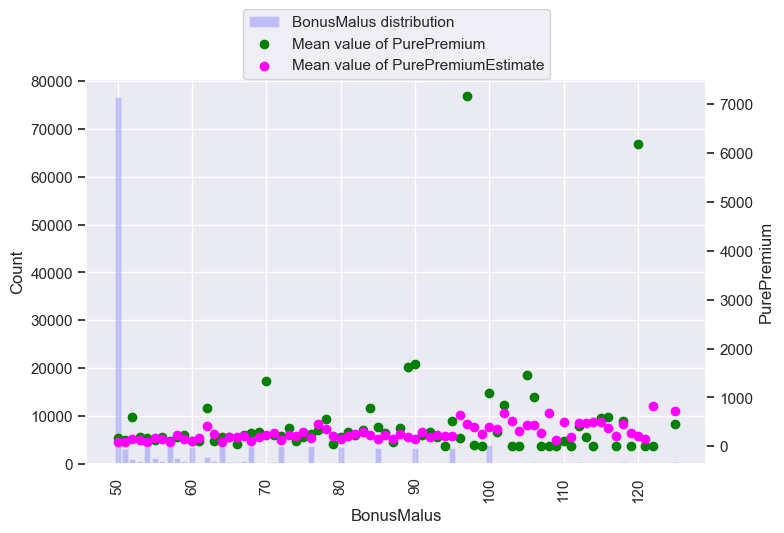

In [159]:
pure_premium_test = df_claims[~train_mask].copy()
pure_premium_test["PurePremiumEstimate"] = estimate_pure_premium(pure_premium_test, xgb_regressor, xgb_sev)

for feature in ["VehAge", "DrivAge", "BonusMalus"]:
    plot_feature_influence(pure_premium_test, feature, "PurePremium", estimate="PurePremiumEstimate")

# 7 Total Claim Estimation

In [160]:
total_claim = []

for label, mask in [("Train set", train_mask), ("Test set", ~train_mask)]:
    total_claim_observed = np.sum(df_claims[mask]["ClaimAmount"])
    pure_premium_estimated = estimate_pure_premium(df_claims.loc[mask], xgb_regressor, xgb_sev)
    total_claim_estimated = np.sum(pure_premium_estimated * df_claims.loc[mask]["Exposure"])
    total_claim.append(
        {
            "subset": label,
            "observed total claim": total_claim_observed,
            "estimated total claim": total_claim_estimated
        }
    )

pd.DataFrame(total_claim).set_index("subset").T

subset,Train set,Test set
observed total claim,3.613721e+07,8.615949e+06
estimated total claim,3.190110e+07,7.969306e+06


# 8 Test Section

In [161]:
test_data = pd.DataFrame([{
    'VehPower': 2,
    'VehAge': 18,
    'DrivAge': 25,
    'VehGas': "Regular",
    'Exposure': 1 / 365,
    'BonusMalus': df_claims["BonusMalus"].median(),
    'Density': df_claims["Density"].median(),
    'VehBrand': df_claims["VehBrand"].mode()[0],
    'Area': df_claims["Area"].mode()[0],
    'Region': df_claims["Region"].mode()[0]
}])

print(f"Estimated pure premium: {estimate_pure_premium(test_data, xgb_regressor, xgb_sev)[0]}")

Estimated pure premium: 29.577274322509766


# Bonus: Classification

In [162]:
target = "ClaimIncident"

data_classification = df_claims.copy()
data_classification[target] = data_classification["ClaimAmount"].apply(lambda val: 1 if val > 0 else 0)

In [163]:
data_classification.groupby(target, group_keys=False).apply(lambda df: df.sample(2))

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount,ClaimIncident
IDpol,,,,,,,,,,,,,,,,
5055792.0,0.0,0.49,C,9.0,5.0,46.0,76.0,B13,Regular,127.0,R72,0.00,0.000000,0.00000,0.00,0
3242383.0,0.0,0.07,C,6.0,17.0,33.0,64.0,B1,Diesel,171.0,R93,0.00,0.000000,0.00000,0.00,0
3167037.0,1.0,0.94,E,5.0,4.0,35.0,106.0,B2,Regular,3744.0,R93,1727.65,1837.925532,1.06383,1727.65,1
2263569.0,1.0,0.50,E,14.0,2.0,52.0,50.0,B3,Regular,8455.0,R82,1599.91,3199.820000,2.00000,1599.91,1


### Feature Engineering

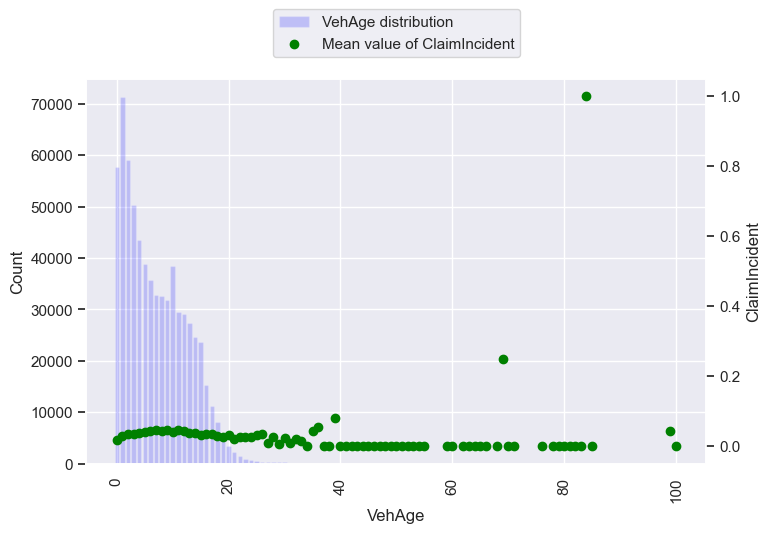

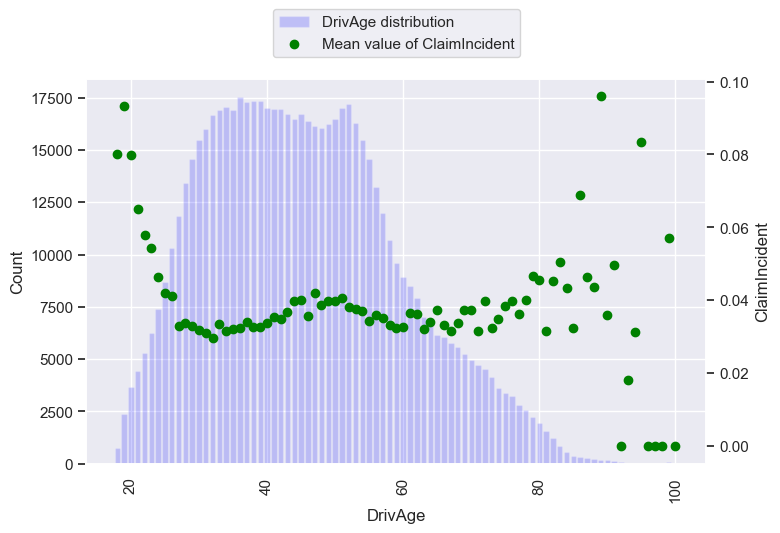

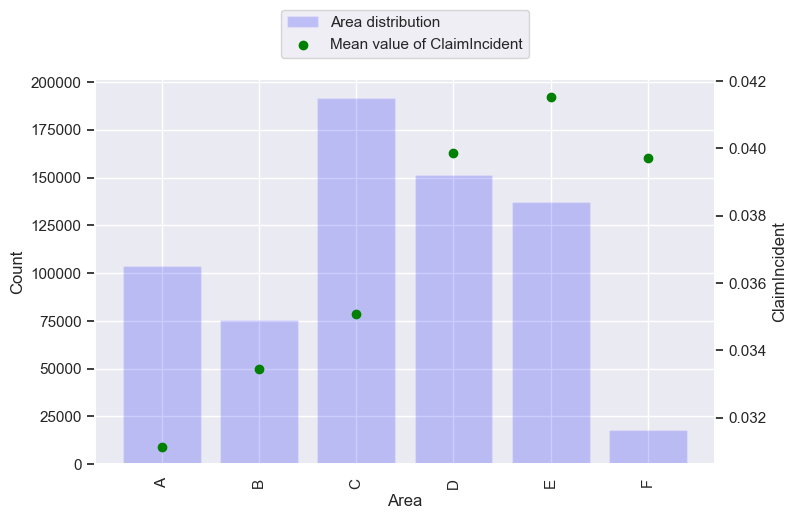

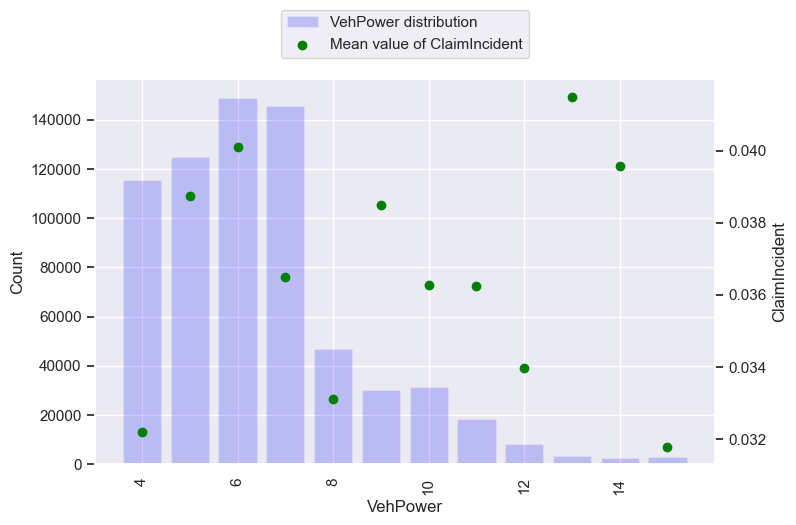

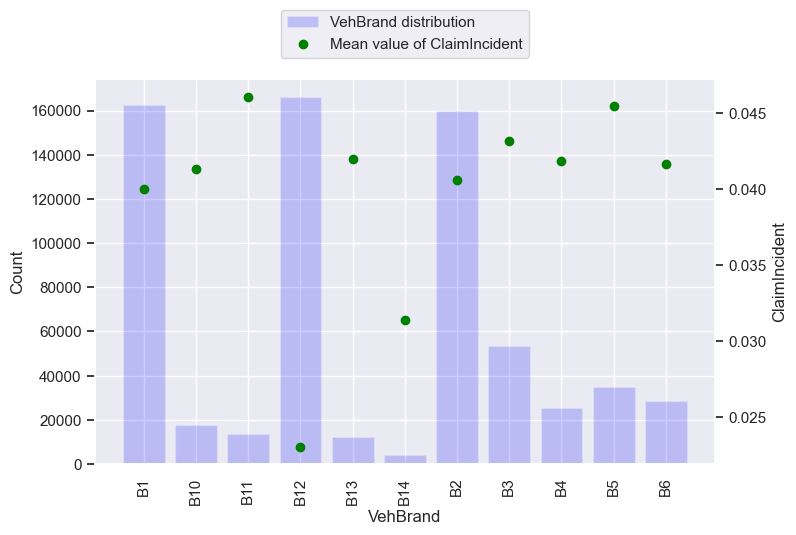

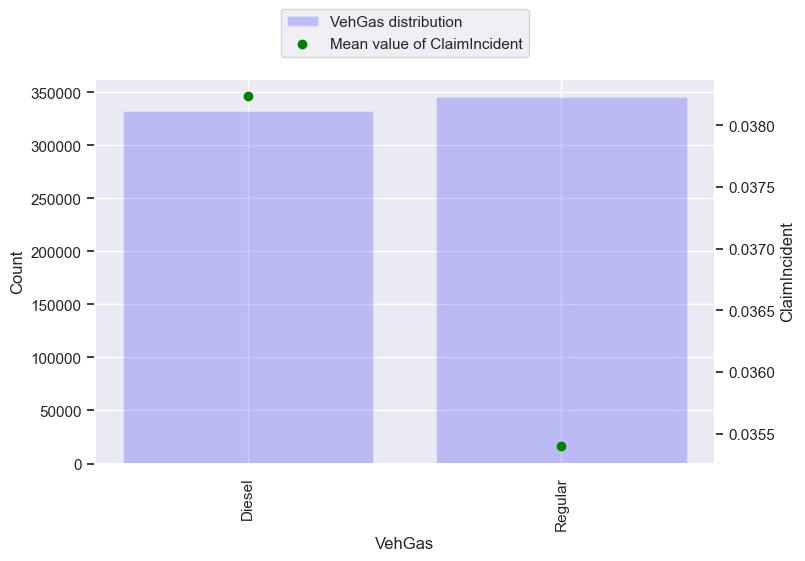

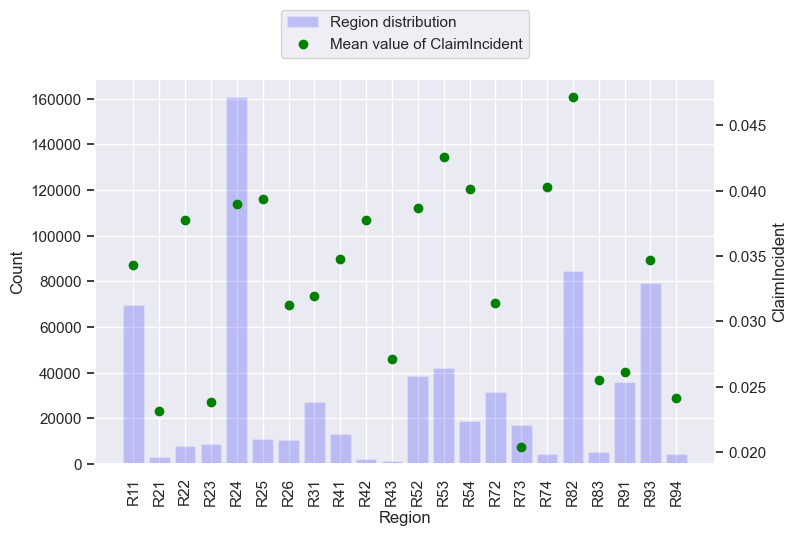

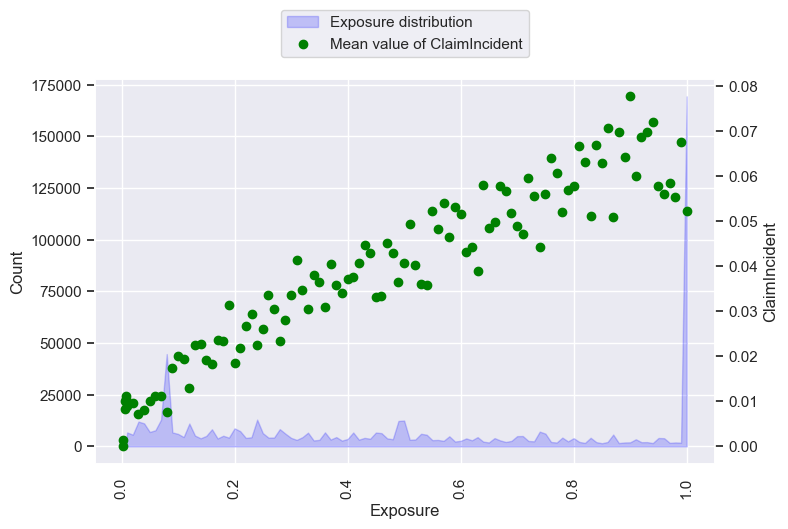

In [164]:
for feature in ["VehAge", "DrivAge", "Area", "VehPower", "VehBrand", "VehGas", "Region", "Exposure"]:
    plot_feature_influence(data_classification, feature, target)

In [165]:
xgb_class_data = data_classification.copy()

for col in ["Region", "VehGas", "Area", "VehBrand"]:
    encoder = TargetEncoder(smoothing=2.0, min_samples_leaf=2)
    xgb_class_data[col] = encoder.fit_transform(xgb_class_data[col], xgb_class_data[target])

xgb_class_data["DriverAgeGroup"] = pd.cut(xgb_class_data["DrivAge"], [0, 27, 70, 100], labels=["YoungDriver", "AvgAgeDriver", "OldDriver"])
xgb_class_data["VehAgeGroup"] = pd.cut(xgb_class_data["VehAge"], [-1, 2, 20, 100], labels=["NewVeh", "AvgAgeVeh", "OldVeh"])

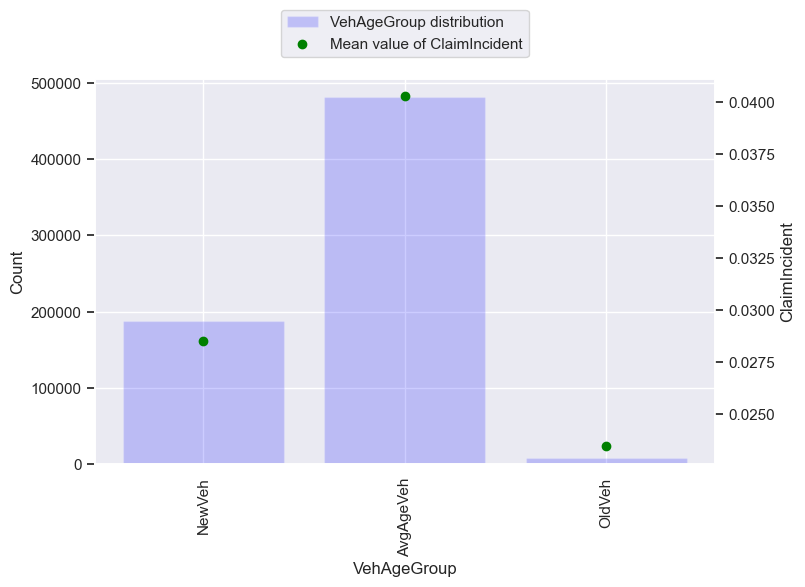

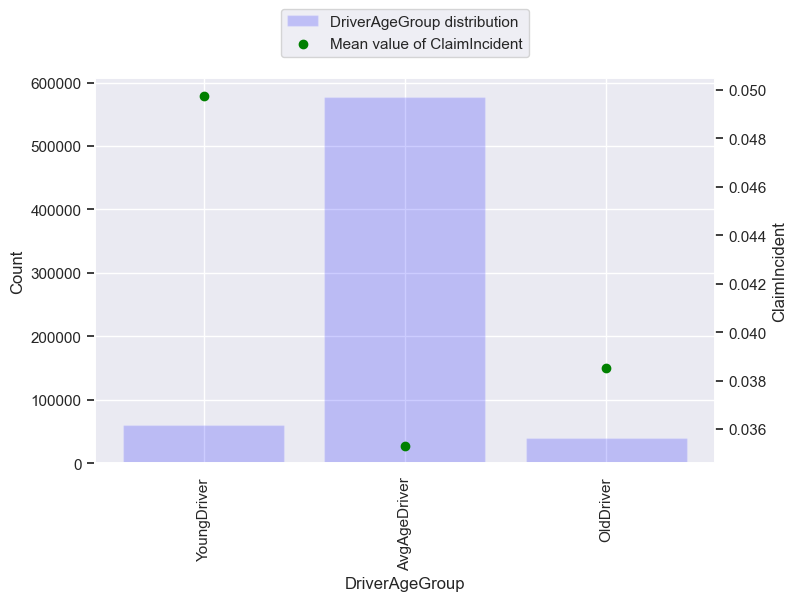

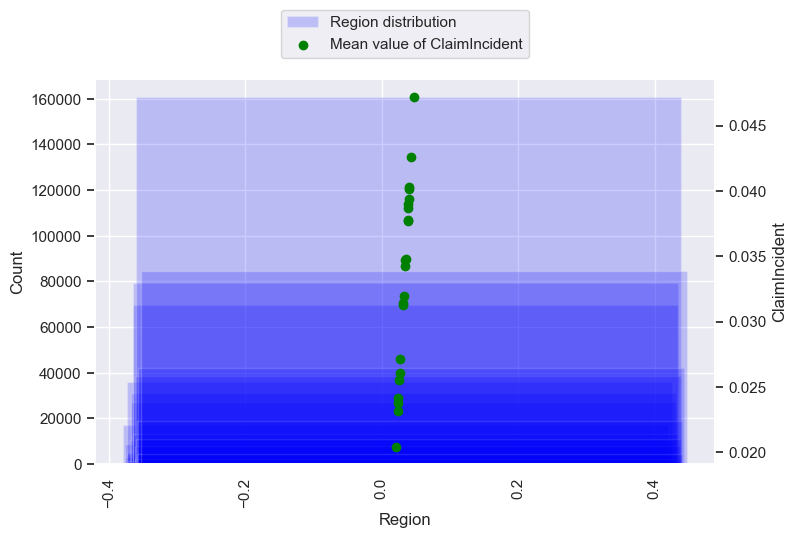

In [166]:
plot_feature_influence(xgb_class_data, "VehAgeGroup", target)
plot_feature_influence(xgb_class_data, "DriverAgeGroup", target)
plot_feature_influence(xgb_class_data, "Region", target)

In [167]:
dummies_driv_age = pd.get_dummies(xgb_class_data["DriverAgeGroup"])
dummies_veh_age = pd.get_dummies(xgb_class_data["VehAgeGroup"])

new = pd.concat([xgb_class_data, dummies_driv_age, dummies_veh_age], axis=1)

### Feature Selection

In [168]:
features = [
    "NewVeh",
    "AvgAgeVeh",
    "OldVeh",
    "YoungDriver",
    "AvgAgeDriver",
    "OldDriver",
    "VehPower",
    "BonusMalus",
    "Density",
    "Region",
    "Area",
    "VehBrand"
]

In [169]:
data_claim = new[new[target] == 1]
data_no_claim = new[new[target] == 0].sample(3 * data_claim.shape[0])

data_classification_balanced = pd.concat([data_claim, data_no_claim])

X_train_te, X_test_te, y_train_te, y_test_te = train_test_split(new[features], new[target], random_state=0, test_size=0.1)

<AxesSubplot: >

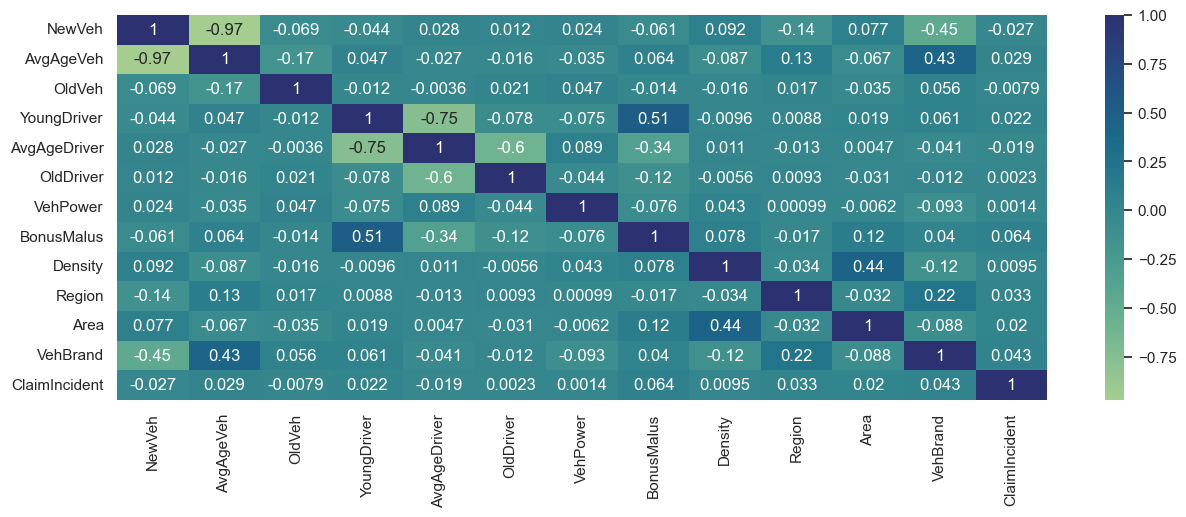

In [170]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(new[features + [target]].corr(), annot=True, fmt='.2g', cmap="crest")

### XGBoost Classifier

In [171]:
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", early_stopping_rounds=10, scale_pos_weight=1, min_child_weight=1)
xgb_classifier.fit(X_train_te, y_train_te, eval_set=[(X_test_te, y_test_te)])
f1_score(y_test_te, xgb_classifier.predict(X_test_te))

[0]	validation_0-logloss:0.47306
[1]	validation_0-logloss:0.35334
[2]	validation_0-logloss:0.28047
[3]	validation_0-logloss:0.23392
[4]	validation_0-logloss:0.20375
[5]	validation_0-logloss:0.18415
[6]	validation_0-logloss:0.17130
[7]	validation_0-logloss:0.16319
[8]	validation_0-logloss:0.15812
[9]	validation_0-logloss:0.15488
[10]	validation_0-logloss:0.15304
[11]	validation_0-logloss:0.15171
[12]	validation_0-logloss:0.15099
[13]	validation_0-logloss:0.15066
[14]	validation_0-logloss:0.15036
[15]	validation_0-logloss:0.15024
[16]	validation_0-logloss:0.15018
[17]	validation_0-logloss:0.15004
[18]	validation_0-logloss:0.15001
[19]	validation_0-logloss:0.14990
[20]	validation_0-logloss:0.14991
[21]	validation_0-logloss:0.14990
[22]	validation_0-logloss:0.14986
[23]	validation_0-logloss:0.14982
[24]	validation_0-logloss:0.14983
[25]	validation_0-logloss:0.14985
[26]	validation_0-logloss:0.14982
[27]	validation_0-logloss:0.14982
[28]	validation_0-logloss:0.14981
[29]	validation_0-loglos

0.0008123476848090984

In [172]:
print(classification_report(y_test_te, xgb_classifier.predict(X_test_te)))
print(confusion_matrix(y_test_te, xgb_classifier.predict(X_test_te)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     65346
           1       0.17      0.00      0.00      2456

    accuracy                           0.96     67802
   macro avg       0.57      0.50      0.49     67802
weighted avg       0.93      0.96      0.95     67802

[[65341     5]
 [ 2455     1]]
